In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pip install pystan
!pip install fbprophet

In [3]:
data = pd.read_csv('/content/training data.xls',parse_dates = ['Week Start Date'])
                                      
data.head(5)

,Product Name,Week Start Date,Weekly Demand Quantity
0,Chocolate,2018-07-07,3198
1,Chocolate,2018-07-14,12181
2,Chocolate,2018-07-21,13494
3,Chocolate,2018-07-28,17963
4,Chocolate,2018-08-04,11009


Text(0, 0.5, 'Demand')

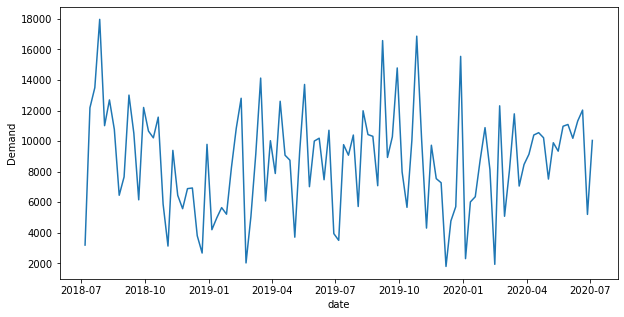

In [4]:
plt.figure(figsize=(10,5))
plt.plot(data['Week Start Date'],data['Weekly Demand Quantity'])
plt.xlabel('date')
plt.ylabel('Demand')

Every Time Series has 2 components Systematic and Non-Systematic components.

Systematic component have consistency and can be modeled. Example Trend, Seasonality and Level.

Non-Systematic component can not be modeled directly. Example noise.

Level (L): The average value in the series.

Trend (T): The increasing or decreasing value in the series.

Seasonality (S): The repeating short-term cycle in the series.

Noise (N): The random variation in the series

While modeling a Time Series we can assume it to be a Additive model or a Multiplicative model.

Additive model--

y(t) = L + T + S + N

Multiplicative model--

y(t) = L* T * S * N

In [5]:
data = data.drop(columns='Product Name')

In [6]:
data.dtypes

Week Start Date           datetime64[ns]
Weekly Demand Quantity             int64
dtype: object

In [7]:
from fbprophet import Prophet

In [8]:
data.rename(columns = {'Week Start Date' : 'ds', 'Weekly Demand Quantity': 'y'}, inplace = True)

In [9]:
data.head()

,ds,y
0,2018-07-07,3198
1,2018-07-14,12181
2,2018-07-21,13494
3,2018-07-28,17963
4,2018-08-04,11009


## Prophet

In [10]:
from fbprophet import Prophet

In [11]:
m = Prophet(interval_width=0.95, weekly_seasonality= True, yearly_seasonality= True)
model = m.fit(data)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
future = m.make_future_dataframe(periods=9,freq='W')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-07-07,4452.303081,1075.585104,12272.232938,4452.303081,4452.303081,2094.836196,2094.836196,2094.836196,3778.60064,3778.60064,3778.60064,-1683.764443,-1683.764443,-1683.764443,0.0,0.0,0.0,6547.139278
1,2018-07-14,4461.947210,2638.686386,13454.194701,4461.947210,4461.947210,3823.091364,3823.091364,3823.091364,3778.60064,3778.60064,3778.60064,44.490724,44.490724,44.490724,0.0,0.0,0.0,8285.038574
2,2018-07-21,4471.591339,5455.263876,16149.440445,4471.591339,4471.591339,6397.641340,6397.641340,6397.641340,3778.60064,3778.60064,3778.60064,2619.040700,2619.040700,2619.040700,0.0,0.0,0.0,10869.232679
3,2018-07-28,4481.235467,7287.375692,17889.923933,4481.235467,4481.235467,8201.897178,8201.897178,8201.897178,3778.60064,3778.60064,3778.60064,4423.296538,4423.296538,4423.296538,0.0,0.0,0.0,12683.132645
4,2018-08-04,4490.879598,7477.087298,17524.470775,4490.879598,4490.879598,7900.359026,7900.359026,7900.359026,3778.60064,3778.60064,3778.60064,4121.758386,4121.758386,4121.758386,0.0,0.0,0.0,12391.238624


In [13]:
forecast[['ds','yhat']]

,ds,yhat
0,2018-07-07,6547.139278
1,2018-07-14,8285.038574
2,2018-07-21,10869.232679
3,2018-07-28,12683.132645
4,2018-08-04,12391.238624
...,...,...
109,2020-08-02,9240.436723
110,2020-08-09,7462.319713
111,2020-08-16,5425.967988
112,2020-08-23,4994.124292


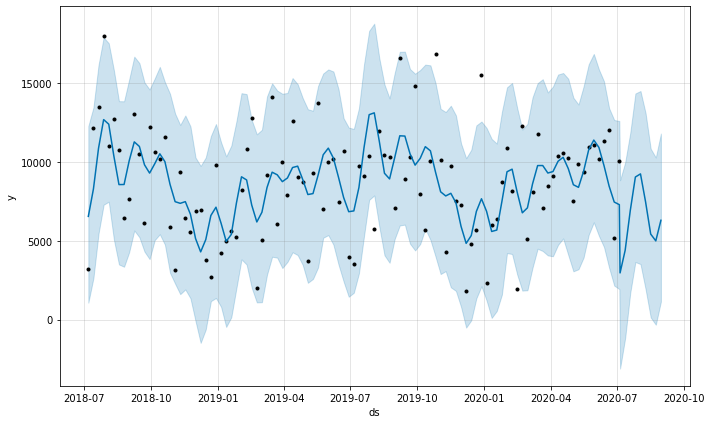

In [14]:
plot1 = m.plot(forecast)


blue line is the prediction

blue region represent upper and lower yhat

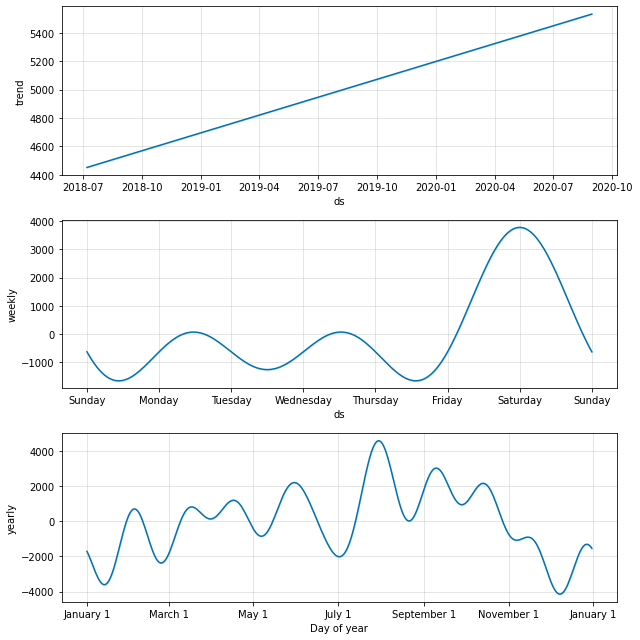

In [15]:
plot3 = m.plot_components(forecast)

In [16]:
test_data = pd.read_csv('/content/test data.xls')
                  

In [17]:
test_data = test_data.drop(columns='Product Name')

In [18]:
test_data.rename(columns = {'Week Start Date' : 'ds'}, inplace = True)

In [19]:
test_data

,ds,Weekly Demand Quantity
0,11-Jul-20,5502
1,18-Jul-20,11564
2,25-Jul-20,17374
3,1-Aug-20,8520
4,8-Aug-20,6015
5,15-Aug-20,11287
6,22-Aug-20,12076
7,29-Aug-20,6304


In [20]:
prediction = forecast[['ds','yhat']][-8:]
prediction.set_index('ds')

,yhat
ds,
2020-07-12,4397.950256
2020-07-19,6914.415781
2020-07-26,9042.475271
2020-08-02,9240.436723
2020-08-09,7462.319713
2020-08-16,5425.967988
2020-08-23,4994.124292
2020-08-30,6299.494316


In [21]:
prediction

,ds,yhat
106,2020-07-12,4397.950256
107,2020-07-19,6914.415781
108,2020-07-26,9042.475271
109,2020-08-02,9240.436723
110,2020-08-09,7462.319713
111,2020-08-16,5425.967988
112,2020-08-23,4994.124292
113,2020-08-30,6299.494316


In [22]:
y_test = np.array(test_data['Weekly Demand Quantity'])
y_pred = np.array(prediction['yhat'])

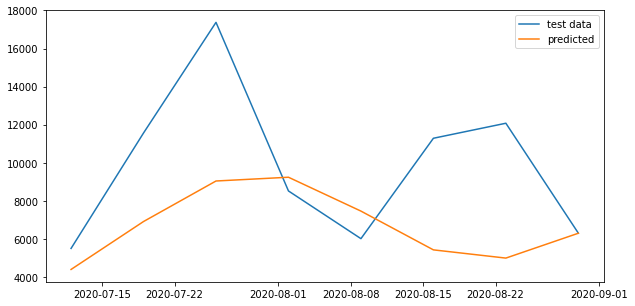

In [23]:
plt.figure(figsize = (10,5))
plt.plot(prediction['ds'],y_test, label = 'test data')
plt.plot(prediction['ds'],y_pred, label = 'predicted')
plt.legend()

In [24]:
print('MAPE error', np.round(np.average(np.abs(y_test - y_pred)/y_test)*100,2))

MAPE error 31.42


## ARIMA

In [25]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters

In [26]:
train_df = pd.read_csv('/content/training data.xls',
                       parse_dates = ['Week Start Date'],
                       index_col = ['Week Start Date'])

In [27]:
train_df = train_df.drop(['Product Name'], axis = 1)

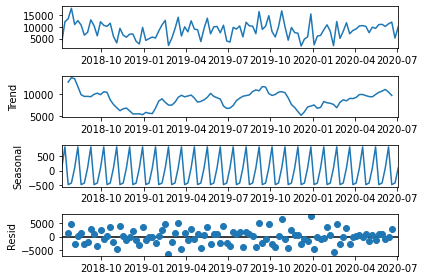

In [52]:
series = train_df[['Weekly Demand Quantity']]
result = seasonal_decompose(series, model = 'additive' ,period=4)
result.plot()
plt.show()

In [53]:
from statsmodels.tsa.stattools import adfuller # check for stationarity


def ad_test(dataset):
  df_traintest= adfuller (dataset , autolag = 'AIC')
  print("1. ADF :", df_traintest[0])
  print("2. P-Value :", df_traintest[1])
  print("3. Num of Lags", df_traintest[2])
  print("4. Num of Observation used for ADF Regression and Critical Values Calculation :",df_traintest[3])
  print("5. Critical Values :")
  for key, val in df_traintest[4].items():
    print("\t", key, ":", val)

In [54]:
ad_test(train_df["Weekly Demand Quantity"])

1. ADF : -3.8640478908098204
2. P-Value : 0.002315957563556924
3. Num of Lags 3
4. Num of Observation used for ADF Regression and Critical Values Calculation : 101
5. Critical Values :
	 1% : -3.4968181663902103
	 5% : -2.8906107514600103
	 10% : -2.5822770483285953


P value is small means data is stationary as yeh value is less than 0.5


In [ ]:
!pip install pmdarima

In [30]:
from pmdarima import auto_arima

In [56]:
stepwise_fit = auto_arima(train_df["Weekly Demand Quantity"], start_p = 1, startq=1, max_p=6, max_q=6, m=12, start_P=0, seasonal = True, d=0, D=1,trace= True,error_action="ignore" ,suppress_warnings= True, stepwise=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1813.002, Time=1.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1863.130, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1827.291, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1861.154, Time=0.03 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=1867.707, Time=0.17 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=1815.416, Time=1.53 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=1815.050, Time=2.74 sec
 ARIMA(1,0,2)(1,1,0)[12] intercept   : AIC=1833.808, Time=0.57 sec
 ARIMA(1,0,2)(1,1,2)[12] intercept   : AIC=1817.185, Time=3.39 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(1,0,3)(0,1,1)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(0,0,3)(0,1,1)[12] intercept   : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  105
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -900.501
Date:                              Sat, 14 Aug 2021   AIC                           1813.002
Time:                                      12:35:48   BIC                           1828.197
Sample:                                           0   HQIC                          1819.137
                                              - 105                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.3479     57.413      0.076      0.940    -108.179     116.875
ar.L1          0.9865      0.116      8.480      0.000       0.759       1.215
ma.L1         -0.8892      0.165     -5.395      0.000      -1.212      -0.566
ma.L2         -0.0586      0.153     -0.382      0.702      -0.359       0.242
ma.S.L12      -0.8373      0.258     -3.242      0.001      -1.343      -0.331
sigma2      1.946e+07    4.7e-05   4.14e+11      0.000    1.95e+07    1.95e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.88   Prob(JB):                         0.73
Heteroskedasticity (H):               0.90   Skew:                             0.10
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.63e+27. Standard errors may be unstable.
"""

In [63]:
model=ARIMA(train_df["Weekly Demand Quantity"], order= (2,0,2)) # the order used here got from the auto arima function
model=model.fit()
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                                
==================================================================================
Dep. Variable:     Weekly Demand Quantity   No. Observations:                  105
Model:                         ARMA(2, 2)   Log Likelihood                -998.478
Method:                           css-mle   S.D. of innovations           3251.103
Date:                    Sat, 14 Aug 2021   AIC                           2008.956
Time:                            12:43:45   BIC                           2024.880
Sample:                        07-07-2018   HQIC                          2015.409
                             - 07-04-2020                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         8758.8601    516.085     16.972      0.000    7747.353    9770.367
ar.L1.Weekly Demand Quantity     1.7915      0.148     12.074      0.000       1.501       2.082
ar.L2.Weekly Demand Quantity    -0.8547      0.134     -6.377      0.000      -1.117      -0.592
ma.L1.Weekly Demand Quantity    -1.8040      0.101    -17.775      0.000      -2.003      -1.605
ma.L2.Weekly Demand Quantity     0.9075      0.076     11.972      0.000       0.759       1.056
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0481           -0.2676j            1.0817           -0.0398
AR.2            1.0481           +0.2676j            1.0817            0.0398
MA.1            0.9940           -0.3376j            1.0498           -0.0521
MA.2            0.9940           +0.3376j            1.0498            0.0521
-----------------------------------------------------------------------------
"""

In [64]:
model.predict(99,106)

2020-05-30    8754.035454
2020-06-06    8813.597146
2020-06-13    8967.122587
2020-06-20    9128.266676
2020-06-27    9330.188538
2020-07-04    9671.166932
2020-07-11    9682.520769
2020-07-18    9316.087752
Freq: W-SAT, dtype: float64

In [65]:
forecast = np.array(model.predict(99,106))

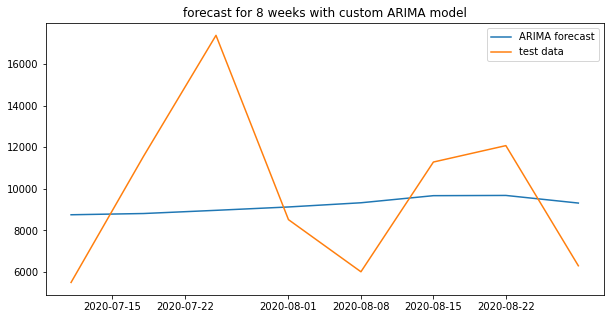

In [66]:
plt.figure(figsize =  (10,5))
plt.plot(pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT'),forecast, label = 'ARIMA forecast')
plt.plot(pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT'),y_test, label = 'test data')
plt.title('forecast for 8 weeks with custom ARIMA model')
plt.legend()
plt.show()

In [87]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def WMAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.sum((np.abs((y_true - y_pred)) / (y_true)) * 100*y_test)/np.sum(y_test)

In [88]:
mape = mean_absolute_percentage_error(y_test,forecast)
print('MAPE',mape)
wmape = WMAPE(y_test,forecast)
print('WMAPE',wmape)

MAPE 38.142203086778956
WMAPE 33.21872756063538


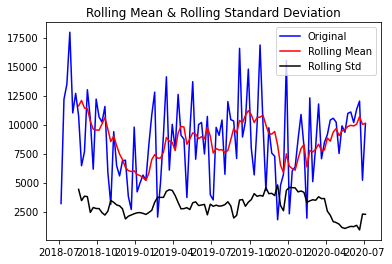

In [69]:
df = train_df
rolling_mean = df.rolling(window = 7).mean()
rolling_std = df.rolling(window = 7).std()

plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

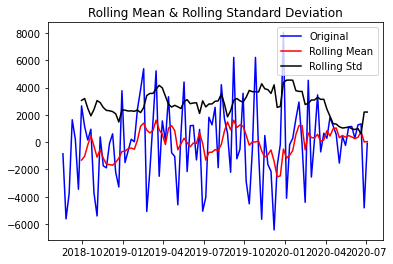

In [70]:
rolling_mean = df.rolling(window=7).mean()
df_minus_mean = df - rolling_mean
df_minus_mean.dropna(inplace=True)

df = df_minus_mean
rolling_mean = df.rolling(window = 7).mean()
rolling_std = df.rolling(window = 7).std()

plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

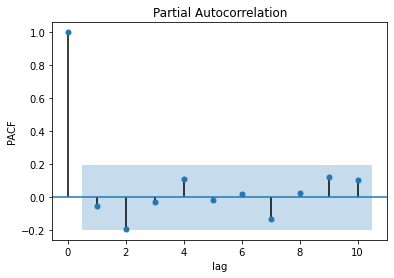

In [71]:
from statsmodels.graphics.tsaplots import plot_pacf
series = df_minus_mean
plot_pacf(series, lags = 10)
plt.xlabel('lag')
plt.ylabel('PACF')
plt.show()

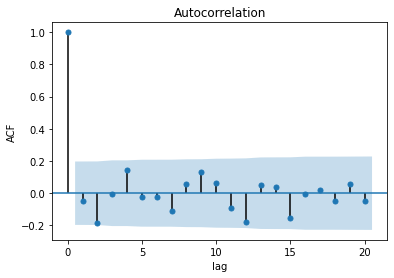

In [72]:
from statsmodels.graphics.tsaplots import plot_acf
series = df_minus_mean
plot_acf(series)
plt.xlabel('lag')
plt.ylabel('ACF')
plt.show()



ACF stands for AutoCorrelationFunction

ACF plot at lag k shows the correlation between the time series observstion seperated by k periods.

So we can take AR order (Autoregression order) to be k for which correlation is high i.e. for that k for which value lie outside the CI in the ACF plot.

Similary PACF is used to decide MA order for ARIMA model.

Note the blue region is 95% CI and vertical lines which cross this region are considered significant.

So we will take 2 as AR order and MA order for our ARIMA model.

Now we will apply ARIMA model to this time series.


In [73]:
AR_order = 2
differencing_order = 0
MA_order = 2
order = (AR_order, differencing_order, MA_order)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.



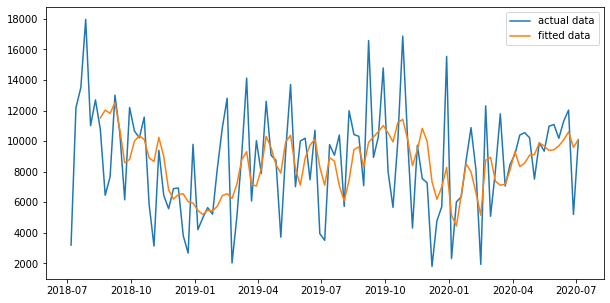

In [74]:
model = ARIMA(df, order= order,)
results = model.fit()

a = np.array(results.fittedvalues).reshape(1,-1)
rolling_mean = train_df.rolling(window=7).mean()
b = np.array(rolling_mean).reshape(1,-1)
#b = 8707.24761905*np.ones(shape=(1,len(a)))
plt.figure(figsize = (10,5))
plt.plot(train_df['Weekly Demand Quantity'], label = 'actual data')
plt.plot(pd.date_range('2018-08-18',periods = 99, freq = 'W-SAT'),sum(a,b[0,6:]).reshape(-1,1), label = 'fitted data')
plt.legend()
plt.show()

In [ ]:
rolling_mean = train_df.rolling(window=7).mean()
rolling_mean = rolling_mean[6:][:]
model = ARIMA(rolling_mean, order= order)
results_for_mean = model.fit()

In [76]:
results_for_mean.predict(99,106)

2020-07-11    10069.775395
2020-07-18     9972.036666
2020-07-25     9896.191507
2020-08-01     9826.627066
2020-08-08     9762.720636
2020-08-15     9704.011193
2020-08-22     9650.076101
2020-08-29     9600.527102
Freq: W-SAT, dtype: float64

In [77]:
results.predict(99,106)

2020-07-11    621.589240
2020-07-18    119.198174
2020-07-25   -644.852975
2020-08-01   -498.258997
2020-08-08    234.499551
2020-08-15    390.343882
2020-08-22   -196.915303
2020-08-29   -563.519021
Freq: W-SAT, dtype: float64

In [78]:
forecast_modified = np.array(results.predict(99,106))
forecast = forecast_modified + np.array(results_for_mean.predict(99,106))

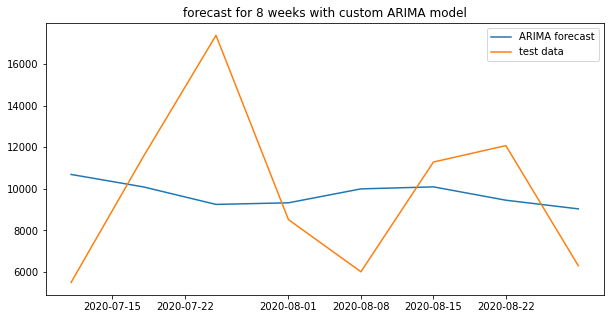

In [79]:
plt.figure(figsize =  (10,5))
plt.plot(pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT'),forecast, label = 'ARIMA forecast')
plt.plot(pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT'),y_test, label = 'test data')
plt.title('forecast for 8 weeks with custom ARIMA model')
plt.legend()
plt.show()

In [80]:
mape = mean_absolute_percentage_error(y_test,forecast)
print('MAPE',mape)
wmape = WMAPE(y_test,forecast)
print('WMAPE',wmape)

MAPE 38.142203086778956
WMAPE 33.21872756063537


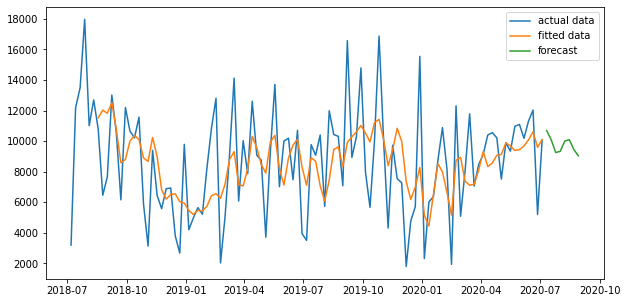

In [81]:
plt.figure(figsize = (10,5))
plt.plot(train_df['Weekly Demand Quantity'], label = 'actual data')
plt.plot(pd.date_range('2018-08-18',periods = 99, freq = 'W-SAT'),sum(a,b[0,6:]).reshape(-1,1), label = 'fitted data')
plt.plot(pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT'),forecast, label = 'forecast')
plt.legend()
plt.show()

## Holts Winter Model

In [45]:
from statsmodels.tsa.holtwinters import Holt

In [46]:
es_model = Holt(train_df, initialization_method="heuristic")
es_result = es_model.fit()
es_forecast = es_result.forecast(8).rename(r'\alpha=%s'%es_result.model.params['smoothing_level'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [47]:
mape = mean_absolute_percentage_error(y_test,es_forecast)
print('MAPE',mape)
wmape = WMAPE(y_test,es_forecast)
print('WMAPE',wmape)

MAPE 37.02213429432457
WMAPE 33.01035070318659


In [48]:
es_forecast

2020-07-11    9569.819226
2020-07-18    9578.808052
2020-07-25    9587.796878
2020-08-01    9596.785704
2020-08-08    9605.774530
2020-08-15    9614.763356
2020-08-22    9623.752182
2020-08-29    9632.741008
Freq: W-SAT, Name: \alpha=0.12285714285714286, dtype: float64

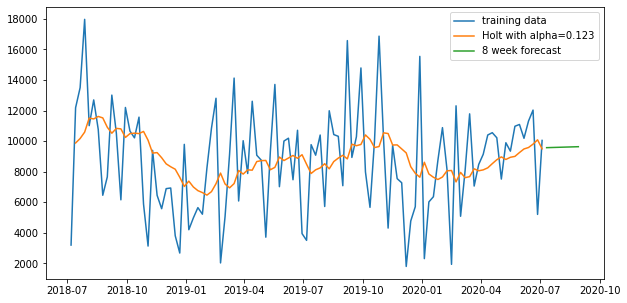

In [49]:
plt.figure(figsize = (10,5))
plt.plot(train_df['Weekly Demand Quantity'], label = 'training data')
plt.plot(es_result.predict(1), label = 'Holt with' + r' alpha=%.3f'%es_result.model.params['smoothing_level'])
plt.plot(es_forecast, label = '8 week forecast')
plt.legend()
plt.show()

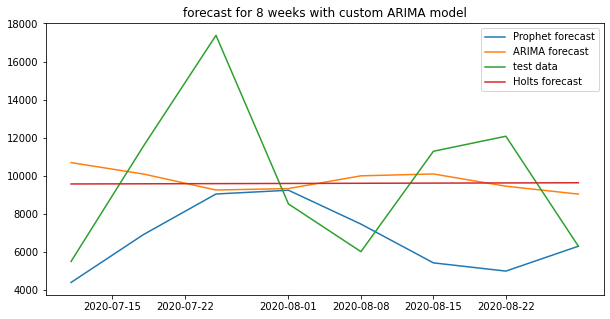

In [50]:
plt.figure(figsize =  (10,5))
plt.plot(pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT'),y_pred, label = 'Prophet forecast')
plt.plot(pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT'),forecast, label = 'ARIMA forecast')
plt.plot(pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT'),y_test, label = 'test data')
plt.plot(pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT'),es_forecast, label = 'Holts forecast')
plt.title('forecast for 8 weeks with custom ARIMA model')
plt.legend()
plt.show()